# 시스템 손절매의 실례: 수익곡선 모멘텀 그림 2-38
- 투자 기간 :1986년 7월~2017년 6월
- 투자자산 : 코스피지수 월봉
- 투자 전략 : 12개월 평균 모멘텀 스코어 전략(연 3% 수익 가정 현금 혼합 전략) + 6개월 평균 모멘텀 스코어 시스템 손절매 전략
    - 12개월 평균 모멘텀 스코어 전략(현금 혼합)으로 전략이 마무리 되는 것이 아니라, 이 수익곡선 자체의 모멘텀 스코어를 매달 평가하여 기본 전략의 투자 비중을 매달 조절하는 전략입니다. 
    - 예를 들어 이번 달의 수익곡선 모멘텀 스코어가 0.75이었다면, 투자 비중은 평균 모멘텀 스코어 전략 75%, 현금 25%가 됩니다. 이중 75%만 전략에 투자합니다.
- 결과
    - 코스피 : 7.2%/-73.1%
    - 평균 모멘텀 스코어 현금 혼합 전략 : 6.4%/-19.1%
    - 수익곡선 모멘텀 전략 : 6.4%/-10.2%
    - 일종의 **시장 적응 전략(Market Adaptive Strategy)**

In [1]:
from settings import *

In [2]:
kospi = fdr.DataReader("KS11")['Close']
kospi

Date
1981-05-01    123.600
1981-05-02    123.500
1981-05-04    120.600
1981-05-06    120.700
1981-05-07    119.300
               ...   
2022-02-08   2746.470
2022-02-09   2768.850
2022-02-10   2771.930
2022-02-11   2747.710
2022-02-14   2704.480
Name: Close, Length: 10888, dtype: float64

# 일일데이터 비중 클래스 구현 
- 일간->월간 변경 후 모멘텀스코어 구하는 법

In [3]:
s='1985-1-30'
e='2017-6-30'
start평균모멘텀스코어='1986-1-31'
start수익곡선모멘텀='1986-7-31'

## 데이타 생성

In [4]:
# kospi = fdr.DataReader("KS11")['Close']
data_daily = pd.DataFrame()
data_daily['KOSPI'] = kospi.copy()
data_daily = data_daily[s:e]
# %%
dd = pd.DataFrame()
# dd.index = pd.date_range('1985', '2020-9-30', freq='D')
dd.index = pd.date_range(s, e, freq='D')
denominator = len(pd.date_range(s, e, freq='D'))/len(pd.date_range(s, e, freq='Y'))
dd['현금'] = pow(1.03, 1/denominator)
dd['현금'] = dd['현금'].shift(1, fill_value=1.0)
dd['현금'] = dd['현금'].cumprod()
#%%
data_daily = pd.merge(data_daily, dd, left_index=True, right_index=True, how='left')

In [5]:
data_daily

,KOSPI,현금
Date,,
1985-01-30,137.970,1.000
1985-01-31,138.900,1.000
1985-02-01,138.840,1.000
1985-02-02,138.480,1.000
1985-02-04,136.870,1.000
...,...,...
2017-06-26,2388.660,2.574
2017-06-27,2391.950,2.574
2017-06-28,2382.560,2.574


In [6]:
data_daily['1986-8'].head()

,KOSPI,현금
Date,,
1986-08-01,267.560,1.045
1986-08-02,271.350,1.045
1986-08-04,270.890,1.045
1986-08-05,268.400,1.045
1986-08-06,262.510,1.045


## 평균모멘텀스코어 WeighAMSWithCash

In [7]:
# 월말에 계산하고 다음월 첫 거래일 종가로 거래 한다고 전재
# 12개월 평균모멘텀스코어 계산

class WeighAMSWithCash(bt.Algo):
    def __init__(self, lags, months, cash):
        super(WeighAMSWithCash, self).__init__()
        self.lags = lags
        self.months = months
        self.cash = cash

    def 평균모멘텀스코어(self, 데이터, 개월):
        초기값 = 0
        for i in range(1, 개월+1):
            초기값 += np.where(데이터 / 데이터.shift(i) > 1, 1, 0)
        return 초기값[-1]/개월

    def AMS(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        average_momentum_score = pd.Series(dtype='float64')
        # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
        for c in prc.columns:
            average_momentum_score[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return average_momentum_score

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        t0 = (target.now - pd.DateOffset(months=self.lags)).strftime("%Y-%m")
        start = (target.now - pd.DateOffset(months=self.lags) - pd.DateOffset(months=self.months)).strftime("%Y-%m")

        print(f"\nprc : {target.now} {t0} ~ {start}")
        prc = target.universe[selected].loc[start:t0].resample('M').last()
        if (len(prc) < self.months+1):
            return False

        # weights = pd.Series(self.평균모멘텀스코어(prc, self.months), index=selected)
        weights = pd.Series(self.AMS(prc), index=selected)
        weights = weights/weights.sum()
        
        # print(self.평균모멘텀스코어(prc, self.months), prc)
        target.temp['weights'] = weights

        return True

In [8]:
def momentum_mixedcash(name, data, lags=0, months=12, cash='현금'):
    st = bt.Strategy(name,
        [
            bt.algos.RunMonthly(run_on_first_date=True,
                                run_on_end_of_period=True, #월말
                                run_on_last_date=False),
            bt.algos.SelectThese(['KOSPI', '현금']),
            WeighAMSWithCash(lags=lags, months=months, cash=cash),
            # WeighAverageMomentumScoreIncludeCash(months),
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
    )
    return bt.Backtest(st, data, initial_capital=100000000)


# def momentum_mixedcash(name, data, months=12):
#     st = bt.Strategy(name,
#         [
#             bt.algos.RunMonthly(), #월초
#             bt.algos.SelectThese(['KOSPI', '현금']),
#             WeighAverageMomentumScoreIncludeCash(months),
#             PrintTempWeights(),
#             bt.algos.Rebalance()
#         ]
#     )
#     return bt.Backtest(st, data, initial_capital=100000000)

In [9]:
bt_daily_현금혼합 = momentum_mixedcash("모멘텀(현금혼합,일간)", data_daily)

In [10]:
r_daily_현금혼합 = bt.run(bt_daily_현금혼합)


prc : 1985-01-30 00:00:00 1985-01 ~ 1984-01

prc : 1985-01-31 00:00:00 1985-01 ~ 1984-01

prc : 1985-02-28 00:00:00 1985-02 ~ 1984-02

prc : 1985-03-30 00:00:00 1985-03 ~ 1984-03

prc : 1985-04-30 00:00:00 1985-04 ~ 1984-04

prc : 1985-05-31 00:00:00 1985-05 ~ 1984-05

prc : 1985-06-29 00:00:00 1985-06 ~ 1984-06

prc : 1985-07-31 00:00:00 1985-07 ~ 1984-07

prc : 1985-08-31 00:00:00 1985-08 ~ 1984-08

prc : 1985-09-30 00:00:00 1985-09 ~ 1984-09

prc : 1985-10-31 00:00:00 1985-10 ~ 1984-10

prc : 1985-11-30 00:00:00 1985-11 ~ 1984-11

prc : 1985-12-26 00:00:00 1985-12 ~ 1984-12

prc : 1986-01-31 00:00:00 1986-01 ~ 1985-01
1986-01-31 00:00:00 모멘텀(현금혼합,일간) KOSPI:0.478 현금:0.522 

prc : 1986-02-28 00:00:00 1986-02 ~ 1985-02
1986-02-28 00:00:00 모멘텀(현금혼합,일간) KOSPI:0.500 현금:0.500 

prc : 1986-03-31 00:00:00 1986-03 ~ 1985-03
1986-03-31 00:00:00 모멘텀(현금혼합,일간) KOSPI:0.500 현금:0.500 

prc : 1986-04-30 00:00:00 1986-04 ~ 1985-04
1986-04-30 00:00:00 모멘텀(현금혼합,일간) KOSPI:0.500 현금:0.500 

prc : 1986-05-

In [11]:
r_daily_현금혼합.set_date_range(start수익곡선모멘텀,e)
r_daily_현금혼합.display()

Stat                 모멘텀(현금혼합,일간)
-------------------  -----------------------
Start                1986-07-31
End                  2017-06-30
Risk-free rate       0.00%

Total Return         582.14%
Daily Sharpe         0.77
Daily Sortino        1.24
CAGR                 6.41%
Max Drawdown         -21.13%
Calmar Ratio         0.30

MTD                  1.07%
3m                   5.56%
6m                   9.43%
YTD                  9.43%
1Y                   11.02%
3Y (ann.)            3.93%
5Y (ann.)            2.98%
10Y (ann.)           3.55%
Since Incep. (ann.)  6.41%

Daily Sharpe         0.77
Daily Sortino        1.24
Daily Mean (ann.)    6.22%
Daily Vol (ann.)     8.08%
Daily Skew           -0.07
Daily Kurt           6.77
Best Day             3.82%
Worst Day            -3.85%

Monthly Sharpe       0.74
Monthly Sortino      1.63
Monthly Mean (ann.)  6.62%
Monthly Vol (ann.)   8.97%
Monthly Skew         0.95
Monthly Kurt         2.57
Best Month           10.91%
Worst Month        

In [12]:
r_daily_현금혼합.prices.resample('MS').first().to_drawdown_series().describe()

,"모멘텀(현금혼합,일간)"
count,372.000
mean,-0.055
std,0.047
min,-0.193
25%,-0.081
50%,-0.050
75%,-0.012
max,0.000


In [13]:
bt_kospi1 = long_only_ew(data_daily, ['KOSPI'], 'KOSPI')
bt_현금1 = long_only_ew(data_daily, ['현금'], '현금')

r_kospi1 = bt.run(bt_kospi1)
r_현금1 = bt.run(bt_현금1)

1985-01-30 00:00:00
1985-01-30 00:00:00


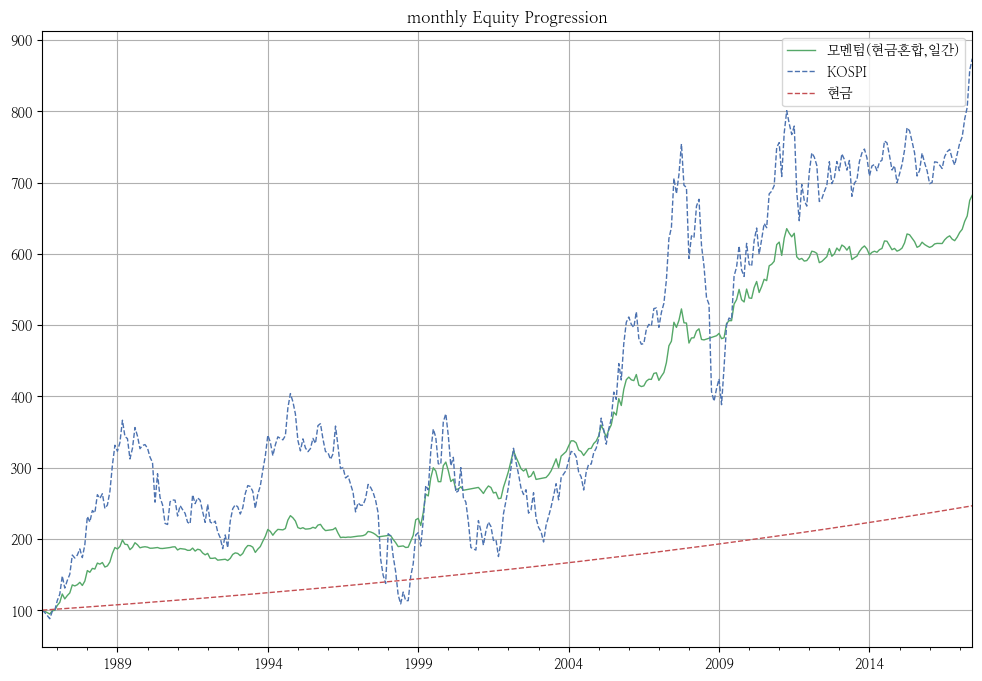

In [14]:
r_kospi1.set_date_range(start수익곡선모멘텀, e)
r_현금1.set_date_range(start수익곡선모멘텀, e)

ax1 = r_daily_현금혼합.plot(freq='M', color='g', figsize=(12,8));
r_kospi1.plot(ax=ax1, freq='M', ls='--', color='b', figsize=(12, 8));
r_현금1.plot(ax=ax1, freq='M', ls='--', color='r', figsize=(12, 8));

In [15]:
r_daily_현금혼합.set_date_range(start평균모멘텀스코어)
r_daily_현금혼합.prices

,"모멘텀(현금혼합,일간)"
1986-01-31,100.000
1986-02-01,100.609
1986-02-03,100.910
1986-02-04,100.723
1986-02-05,100.411
...,...
2017-06-26,901.322
2017-06-27,901.984
2017-06-28,900.234
2017-06-29,902.760


## 수익곡선모멘텀 WeighAMS

In [16]:
# 월말에 계산하고 다음월 첫 거래일 종가로 거래 한다고 전재
# 12개월 평균모멘텀스코어 계산

class WeighAMS(bt.Algo):
    def __init__(self, lags, months, cash):
        super(WeighAMS, self).__init__()
        self.lags = lags
        self.months = months
        self.cash = cash

    def 평균모멘텀스코어(self, 데이터, 개월):
        초기값 = 0
        for i in range(1, 개월+1):
            초기값 += np.where(데이터 / 데이터.shift(i) > 1, 1, 0)
        return 초기값[-1]/개월

    def AMS(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        average_momentum_score = pd.Series(dtype='float64')
        # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
        for c in prc.columns:
            average_momentum_score[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return average_momentum_score

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        t0 = (target.now - pd.DateOffset(months=self.lags)).strftime("%Y-%m")
        start = (target.now - pd.DateOffset(months=self.lags) - pd.DateOffset(months=self.months)).strftime("%Y-%m")

        selected.remove(self.cash)
        prc = target.universe[selected].loc[start:t0].resample('M').last()
        if (len(prc) < self.months+1):
            return False
        print(f"\nprc : {target.now} {t0} ~ {start}")#\n{prc}")

        weights = pd.Series(self.AMS(prc), index=selected)
        weights[self.cash] = 1 - weights.sum()
        # print(self.평균모멘텀스코어(prc, self.months), prc)
        target.temp['weights'] = weights

        return True

In [17]:
수익곡선모멘텀6 = bt.Strategy('수익곡선모멘텀6',
    [
        bt.algos.RunMonthly(run_on_first_date=True,
                            run_on_end_of_period=True, # 월말
                            run_on_last_date=False),
        bt.algos.SelectAll(),
        WeighAMS(lags=0, months = 6, cash='현금'), # lags=0이면 위와 같다.
        PrintTempWeights(),
        bt.algos.Rebalance()
    ]
)

In [18]:
r_daily_현금혼합.prices

,"모멘텀(현금혼합,일간)"
1986-01-31,100.000
1986-02-01,100.609
1986-02-03,100.910
1986-02-04,100.723
1986-02-05,100.411
...,...
2017-06-26,901.322
2017-06-27,901.984
2017-06-28,900.234
2017-06-29,902.760


In [19]:
data_daily_현금혼합 = pd.DataFrame()
data_daily_현금혼합['수익곡선모멘텀6'] = r_daily_현금혼합.prices
# %%
dd = pd.DataFrame()
dd.index = pd.date_range(start평균모멘텀스코어, e, freq='D')
denominator = len(pd.date_range(start평균모멘텀스코어, e, freq='D'))/len(pd.date_range(start평균모멘텀스코어, e, freq='Y'))
dd['현금'] = pow(1.03, 1/denominator)
dd['현금'] = dd['현금'].shift(1, fill_value=1.0)
dd['현금'] = dd['현금'].cumprod()
#%%
data_daily_현금혼합 = pd.merge(data_daily_현금혼합, dd, left_index=True, right_index=True, how='left')

In [20]:
data_daily_현금혼합

,수익곡선모멘텀6,현금
1986-01-31,100.000,1.000
1986-02-01,100.609,1.000
1986-02-03,100.910,1.000
1986-02-04,100.723,1.000
1986-02-05,100.411,1.000
...,...,...
2017-06-26,901.322,2.499
2017-06-27,901.984,2.499
2017-06-28,900.234,2.499
2017-06-29,902.760,2.500


In [21]:
bt_수익곡선모멘텀6 = bt.Backtest(수익곡선모멘텀6, data_daily_현금혼합, initial_capital=100000000)
r_수익곡선모멘텀6 = bt.run(bt_수익곡선모멘텀6)


prc : 1986-07-31 00:00:00 1986-07 ~ 1986-01
1986-07-31 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:1.000 현금:0.000 

prc : 1986-08-30 00:00:00 1986-08 ~ 1986-02
1986-08-30 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:0.833 현금:0.167 

prc : 1986-09-30 00:00:00 1986-09 ~ 1986-03
1986-09-30 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:0.667 현금:0.333 

prc : 1986-10-31 00:00:00 1986-10 ~ 1986-04
1986-10-31 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:0.500 현금:0.500 

prc : 1986-11-29 00:00:00 1986-11 ~ 1986-05
1986-11-29 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:0.833 현금:0.167 

prc : 1986-12-26 00:00:00 1986-12 ~ 1986-06
1986-12-26 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:0.833 현금:0.167 

prc : 1987-01-31 00:00:00 1987-01 ~ 1986-07
1987-01-31 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:1.000 현금:0.000 

prc : 1987-02-28 00:00:00 1987-02 ~ 1986-08
1987-02-28 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:1.000 현금:0.000 

prc : 1987-03-31 00:00:00 1987-03 ~ 1986-09
1987-03-31 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:1.000 현금:0.000 

prc : 1987-04-30 00:00:00 1987-04 ~ 1986-10
1987-04-30 00:00:00 수익곡선모멘텀6 수익곡선모멘텀6:0.833 현금:0.167 

prc : 198

In [22]:
r_수익곡선모멘텀6.set_date_range(start수익곡선모멘텀,e)
r_수익곡선모멘텀6.display()

Stat                 수익곡선모멘텀6
-------------------  -----------------
Start                1986-07-31
End                  2017-06-30
Risk-free rate       0.00%

Total Return         577.87%
Daily Sharpe         0.90
Daily Sortino        1.43
CAGR                 6.39%
Max Drawdown         -13.74%
Calmar Ratio         0.46

MTD                  1.07%
3m                   5.56%
6m                   9.28%
YTD                  9.28%
1Y                   10.45%
3Y (ann.)            4.61%
5Y (ann.)            2.88%
10Y (ann.)           3.40%
Since Incep. (ann.)  6.39%

Daily Sharpe         0.90
Daily Sortino        1.43
Daily Mean (ann.)    6.11%
Daily Vol (ann.)     6.79%
Daily Skew           0.07
Daily Kurt           10.78
Best Day             3.82%
Worst Day            -3.85%

Monthly Sharpe       0.86
Monthly Sortino      2.07
Monthly Mean (ann.)  6.48%
Monthly Vol (ann.)   7.51%
Monthly Skew         1.53
Monthly Kurt         5.42
Best Month           10.91%
Worst Month          -5.62%



## 그림 2.38 (일간)

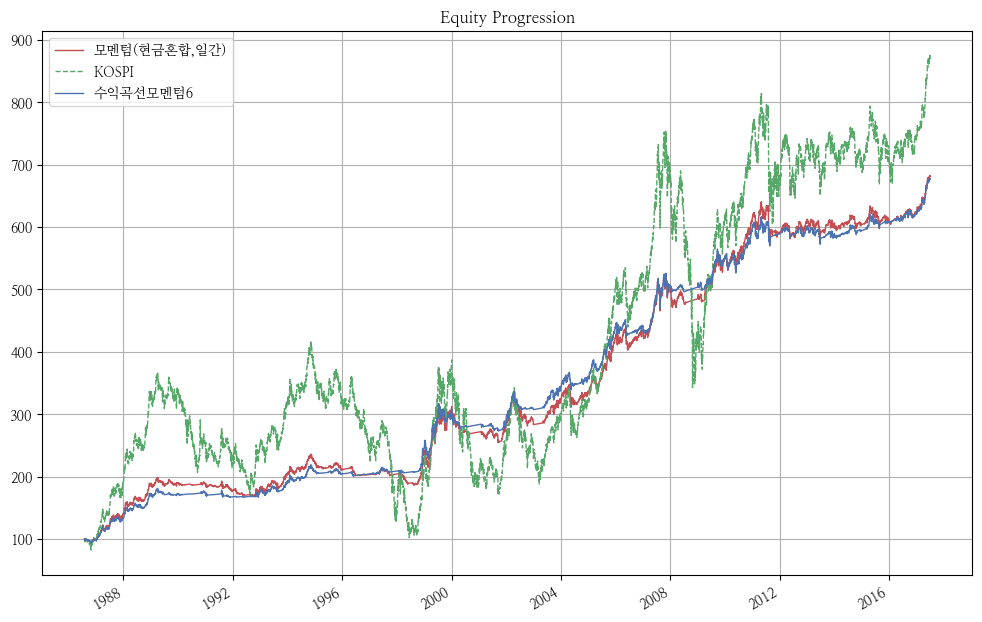

In [23]:
r_daily_현금혼합.set_date_range(start수익곡선모멘텀,e)
r_kospi1.set_date_range(start수익곡선모멘텀,e)
r_수익곡선모멘텀6.set_date_range(start수익곡선모멘텀,e)

ax1 = r_daily_현금혼합.plot(color='r', figsize=(12,8));
r_kospi1.plot(ax=ax1, ls='--', color='g', figsize=(12, 8));
r_수익곡선모멘텀6.plot(ax=ax1, ls='-', color='b', figsize=(12, 8));
#----
# r_ms0.plot(ax=ax1, ls='--', color='gray', figsize=(12, 8));

          CAGR
수익곡선모멘텀6 6.386
             MDD
수익곡선모멘텀6 -13.742


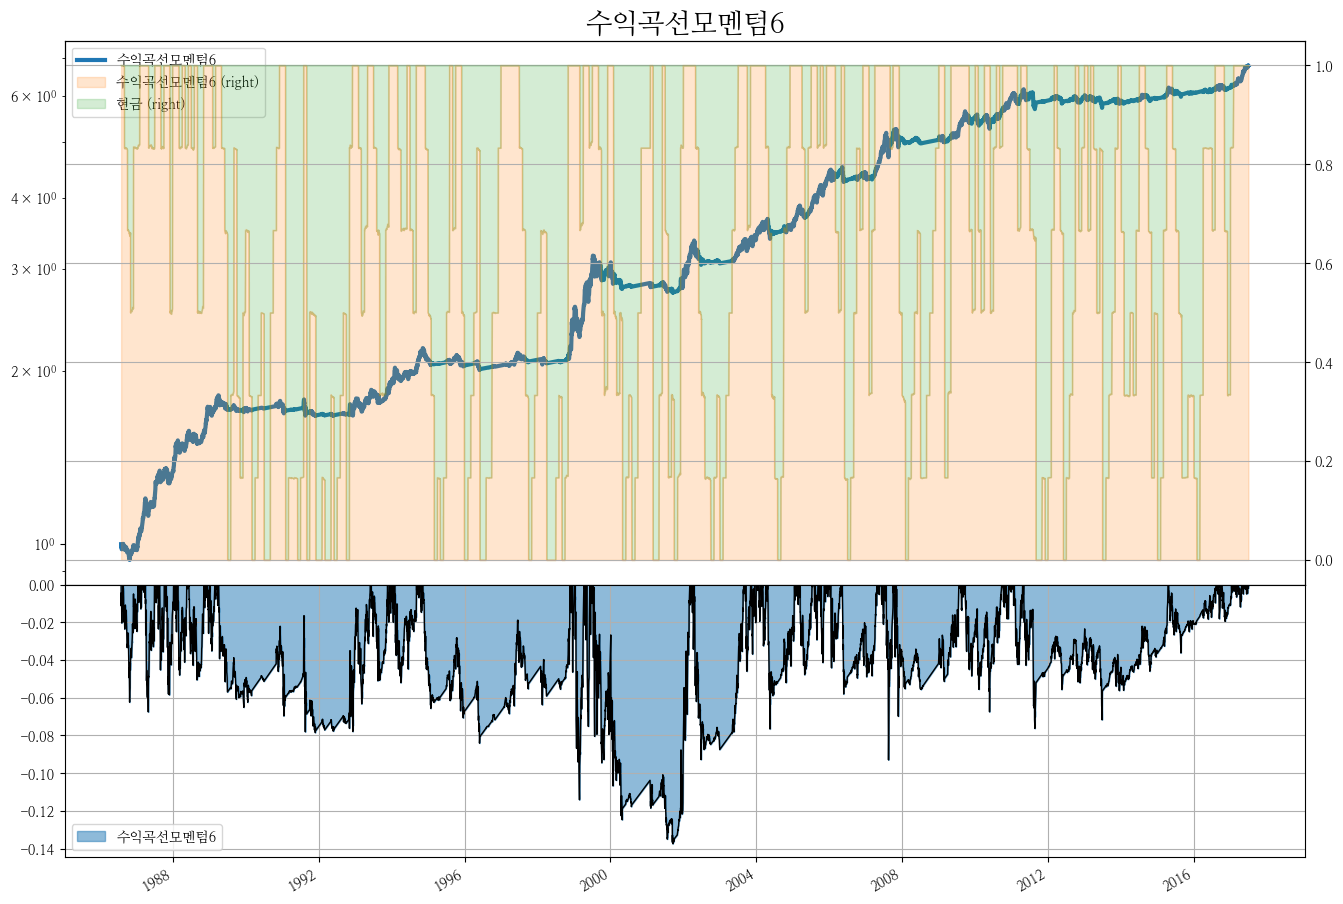

In [24]:
plot_assets(r_수익곡선모멘텀6, start수익곡선모멘텀,e, "수익곡선모멘텀6")

# Children 사용

In [25]:
모멘텀_현금혼합 = bt.Strategy('모멘텀_현금혼합',
        [
            bt.algos.RunMonthly(run_on_first_date=True,
                                run_on_end_of_period=True, #월말
                                run_on_last_date=False),
            bt.algos.SelectThese(['KOSPI', '현금']),
            WeighAMSWithCash(lags=0, months=12, cash='현금'),
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
)

수익곡선모멘텀6_children = bt.Strategy('수익곡선모멘텀6_children',
    [
        bt.algos.RunMonthly(run_on_first_date=True,
                            run_on_end_of_period=True, # 월말
                            run_on_last_date=False),
        bt.algos.SelectAll(),
        WeighAMS(lags=0, months = 6, cash='현금'), # lags=0이면 위와 같다.
        PrintTempWeights(),
        bt.algos.Rebalance()
    ],
    children =[모멘텀_현금혼합, '현금']
)

bt_수익곡선모멘텀6_children = bt.Backtest(수익곡선모멘텀6_children, data_daily, initial_capital=100000000)
r_수익곡선모멘텀6_children = bt.run(bt_수익곡선모멘텀6_children)


prc : 1985-01-30 00:00:00 1985-01 ~ 1984-01

prc : 1985-01-30 00:00:00 1985-01 ~ 1984-01

prc : 1985-01-31 00:00:00 1985-01 ~ 1984-01

prc : 1985-01-31 00:00:00 1985-01 ~ 1984-01

prc : 1985-02-28 00:00:00 1985-02 ~ 1984-02

prc : 1985-02-28 00:00:00 1985-02 ~ 1984-02

prc : 1985-03-30 00:00:00 1985-03 ~ 1984-03

prc : 1985-03-30 00:00:00 1985-03 ~ 1984-03

prc : 1985-04-30 00:00:00 1985-04 ~ 1984-04

prc : 1985-04-30 00:00:00 1985-04 ~ 1984-04

prc : 1985-05-31 00:00:00 1985-05 ~ 1984-05

prc : 1985-05-31 00:00:00 1985-05 ~ 1984-05

prc : 1985-06-29 00:00:00 1985-06 ~ 1984-06

prc : 1985-06-29 00:00:00 1985-06 ~ 1984-06

prc : 1985-07-31 00:00:00 1985-07 ~ 1984-07

prc : 1985-07-31 00:00:00 1985-07 ~ 1985-01
1985-07-31 00:00:00 수익곡선모멘텀6_children 모멘텀_현금혼합:0.000 현금:1.000 

prc : 1985-07-31 00:00:00 1985-07 ~ 1984-07

prc : 1985-08-31 00:00:00 1985-08 ~ 1984-08

prc : 1985-08-31 00:00:00 1985-08 ~ 1985-02
1985-08-31 00:00:00 수익곡선모멘텀6_children 모멘텀_현금혼합:0.000 현금:1.000 

prc : 1985-08-31 0

In [26]:
r_수익곡선모멘텀6_children.set_date_range(start수익곡선모멘텀,e)
r_수익곡선모멘텀6_children.display()

Stat                 수익곡선모멘텀6_children
-------------------  --------------------------
Start                1986-07-31
End                  2017-06-30
Risk-free rate       0.00%

Total Return         577.96%
Daily Sharpe         0.90
Daily Sortino        1.43
CAGR                 6.39%
Max Drawdown         -13.74%
Calmar Ratio         0.46

MTD                  1.07%
3m                   5.56%
6m                   9.28%
YTD                  9.28%
1Y                   10.45%
3Y (ann.)            4.61%
5Y (ann.)            2.88%
10Y (ann.)           3.40%
Since Incep. (ann.)  6.39%

Daily Sharpe         0.90
Daily Sortino        1.43
Daily Mean (ann.)    6.11%
Daily Vol (ann.)     6.79%
Daily Skew           0.07
Daily Kurt           10.78
Best Day             3.82%
Worst Day            -3.85%

Monthly Sharpe       0.86
Monthly Sortino      2.07
Monthly Mean (ann.)  6.48%
Monthly Vol (ann.)   7.51%
Monthly Skew         1.53
Monthly Kurt         5.42
Best Month           10.91%
Worst Month

                   CAGR
수익곡선모멘텀6_children 6.386
                      MDD
수익곡선모멘텀6_children -13.741


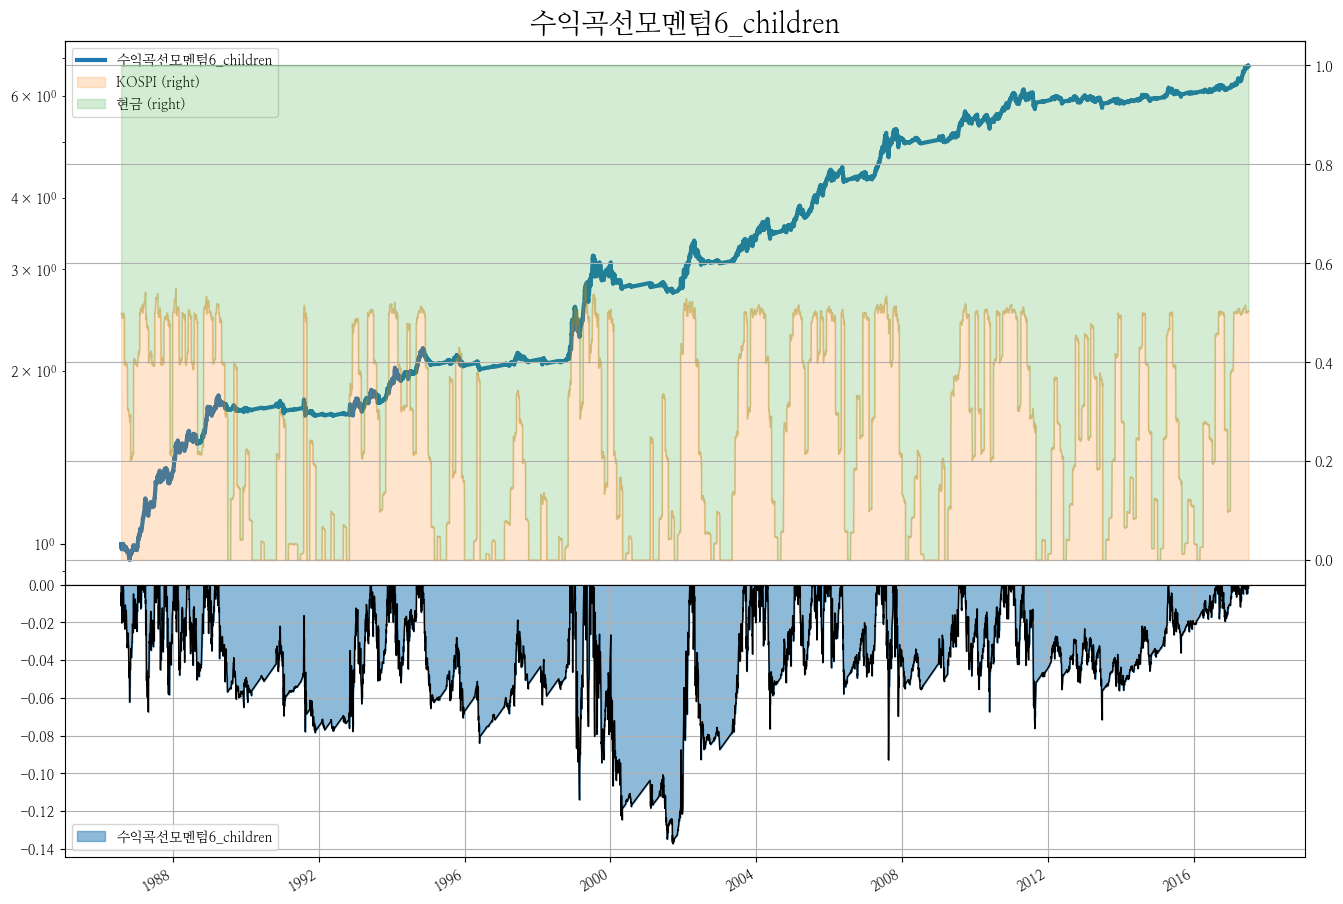

In [27]:
plot_assets(r_수익곡선모멘텀6_children, start수익곡선모멘텀,e, "수익곡선모멘텀6_children")

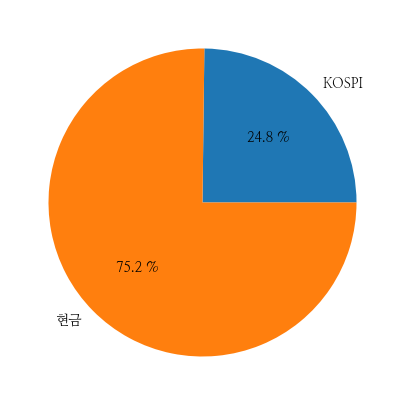

In [28]:
r_수익곡선모멘텀6_children.get_security_weights()[start수익곡선모멘텀:e].sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(5,5));

<AxesSubplot:>

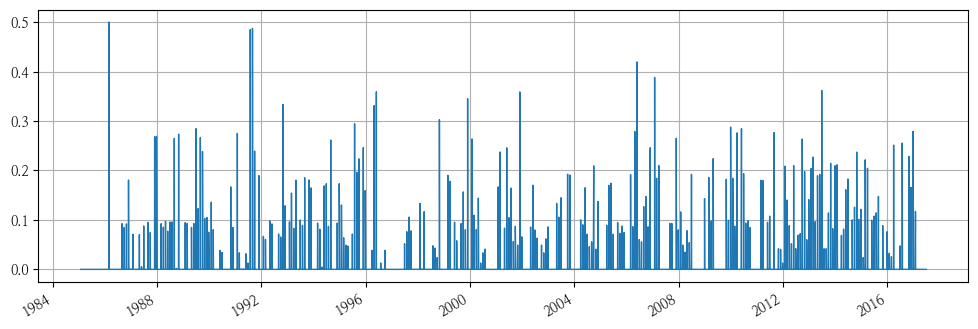

In [29]:
bt_수익곡선모멘텀6_children.turnover.plot(figsize=(12,4))

In [30]:
r_수익곡선모멘텀6_children.get_transactions()

price      quantity
Date       Security                       
1985-07-31 현금          1.015  98556545.000
1986-02-28 KOSPI     175.910    289091.000
           현금          1.032 -98556545.000
1986-03-31 KOSPI     199.760    -16942.000
1986-04-30 KOSPI     202.910     -1791.000
...                      ...           ...
2017-01-31 현금          2.544 -52327215.000
2017-02-28 KOSPI    2091.640      -904.000
2017-03-31 KOSPI    2160.230     -2840.000
2017-04-28 KOSPI    2205.440     -1746.000
2017-05-31 KOSPI    2347.380     -5479.000

[635 rows x 2 columns]

In [31]:
bt_모멘텀_현금혼합 = bt.Backtest(모멘텀_현금혼합, data_daily, initial_capital=100000000)
r_모멘텀_현금혼합 = bt.run(bt_모멘텀_현금혼합)



prc : 1985-01-30 00:00:00 1985-01 ~ 1984-01

prc : 1985-01-31 00:00:00 1985-01 ~ 1984-01

prc : 1985-02-28 00:00:00 1985-02 ~ 1984-02

prc : 1985-03-30 00:00:00 1985-03 ~ 1984-03

prc : 1985-04-30 00:00:00 1985-04 ~ 1984-04

prc : 1985-05-31 00:00:00 1985-05 ~ 1984-05

prc : 1985-06-29 00:00:00 1985-06 ~ 1984-06

prc : 1985-07-31 00:00:00 1985-07 ~ 1984-07

prc : 1985-08-31 00:00:00 1985-08 ~ 1984-08

prc : 1985-09-30 00:00:00 1985-09 ~ 1984-09

prc : 1985-10-31 00:00:00 1985-10 ~ 1984-10

prc : 1985-11-30 00:00:00 1985-11 ~ 1984-11

prc : 1985-12-26 00:00:00 1985-12 ~ 1984-12

prc : 1986-01-31 00:00:00 1986-01 ~ 1985-01
1986-01-31 00:00:00 모멘텀_현금혼합 KOSPI:0.478 현금:0.522 

prc : 1986-02-28 00:00:00 1986-02 ~ 1985-02
1986-02-28 00:00:00 모멘텀_현금혼합 KOSPI:0.500 현금:0.500 

prc : 1986-03-31 00:00:00 1986-03 ~ 1985-03
1986-03-31 00:00:00 모멘텀_현금혼합 KOSPI:0.500 현금:0.500 

prc : 1986-04-30 00:00:00 1986-04 ~ 1985-04
1986-04-30 00:00:00 모멘텀_현금혼합 KOSPI:0.500 현금:0.500 

prc : 1986-05-31 00:00:00 1986

In [32]:
r_모멘텀_현금혼합.set_date_range(start수익곡선모멘텀,e)
r_모멘텀_현금혼합.display()

Stat                 모멘텀_현금혼합
-------------------  -----------------
Start                1986-07-31
End                  2017-06-30
Risk-free rate       0.00%

Total Return         582.14%
Daily Sharpe         0.77
Daily Sortino        1.24
CAGR                 6.41%
Max Drawdown         -21.13%
Calmar Ratio         0.30

MTD                  1.07%
3m                   5.56%
6m                   9.43%
YTD                  9.43%
1Y                   11.02%
3Y (ann.)            3.93%
5Y (ann.)            2.98%
10Y (ann.)           3.55%
Since Incep. (ann.)  6.41%

Daily Sharpe         0.77
Daily Sortino        1.24
Daily Mean (ann.)    6.22%
Daily Vol (ann.)     8.08%
Daily Skew           -0.07
Daily Kurt           6.77
Best Day             3.82%
Worst Day            -3.85%

Monthly Sharpe       0.74
Monthly Sortino      1.63
Monthly Mean (ann.)  6.62%
Monthly Vol (ann.)   8.97%
Monthly Skew         0.95
Monthly Kurt         2.57
Best Month           10.91%
Worst Month          -5.62%



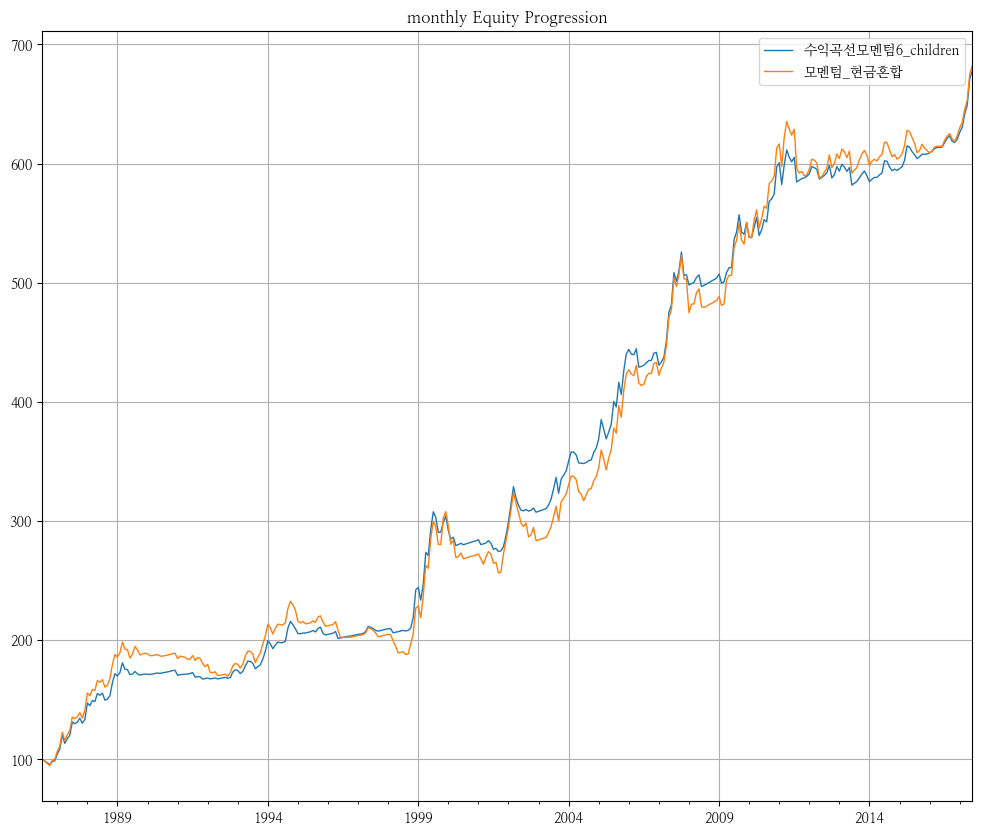

In [33]:
ax1 = r_수익곡선모멘텀6_children.plot(freq='M',figsize=(12,10));
r_모멘텀_현금혼합.plot(ax=ax1, freq='M',figsize=(12,10));